In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

In [2]:
import sys
sys.path.insert(0,'vp_class/')

In [3]:
from class_ou import OU, ou_gradient

In [4]:
import pickle

with open('EX02_OU', 'rb') as f:
    true_sde = pickle.load(f)
    obs = pickle.load(f)
    obs_time = pickle.load(f)
    obs_sigma = pickle.load(f)
    sde_sigma = pickle.load(f)

In [5]:
torch.set_default_dtype(torch.float64)

1. Simulate prior process, i.e. time-homogeneous OU process whose SDE is given by

$$dX_t = -X_tdt + dW_t$$

Note that the observations come from Gaussian likelihood model with variance 0.01

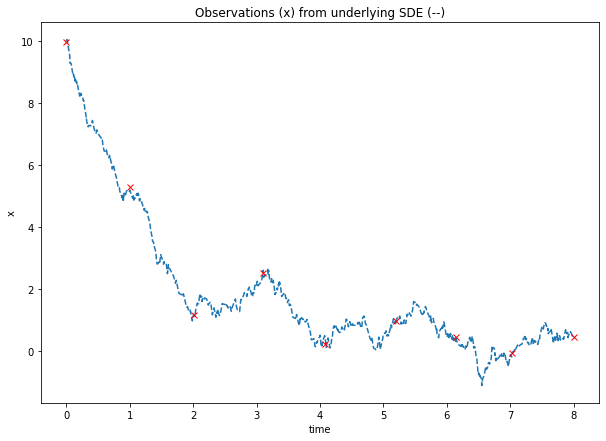

In [6]:
plt.figure(figsize=(10, 7))
plt.title("Observations (x) from underlying SDE (--)")
plt.plot(true_sde.pts.T, true_sde.trj.T, '--')
plt.plot(true_sde.pts[0][::100], obs, 'rx')
plt.xlabel("time")
plt.ylabel("x")
plt.show()

2. Implement Variational inference based on time-homogeneous OU process with SDE:

$$dZ_t = -\beta(Z_t - \alpha)dt + dW_t$$

The KL divergence between the prior and variational process (with equal variance term, $\sigma$) is given by 

$$ \log\exp\frac{dP^{X}}{dP^{Z}}(Z) = \int_{t_{0}}^{t_{1}}\frac{-Z_{t} + \beta (Z_{t}-\alpha)}{\sigma^{2}}dZ_t - \frac{1}{2} \int_{t_{0}}^{t_{1}} \frac{Z^{2}_{t} - \beta^{2}(Z_{t} - \alpha)^{2}}{\sigma^{2}}dt $$

We replace the stochastic integral with the Riemann integral based on Ito's formula.

$$\int_{t_{0}}^{t_{1}} \frac{-Z_t + \beta (Z_t - \alpha)}{\sigma^{2}}dZ_{t} = A(Z_{t_{1}}) - A(Z_{t_{0}}) - \frac{(\beta - 1)(t_{1} - t_{0})}{2}$$

where $A(u)$ is defined by

$$A(u) = \int_{0}^{u}\frac{(\beta - 1)z - \alpha\beta}{\sigma^{2}}dz$$

In [7]:
class ELBO:

    """
        Given a simulated variational process, compute the gradient of the ELBO. 
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha, self.beta, self.sigma =  ou.alpha, ou.beta, ou.sigma
        
    def KL_Riemann(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma = self.alpha, self.beta, self.sigma

        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
        def riemann(z):
            return z * z - beta * beta * ((z - alpha) ** 2)
        
        num = riemann(self.ou.trj)
        
        # re-arrange t so that it starts from 0
        t = self.ou.pts - self.ou.pts[:, 0].reshape(-1, 1) 
        return -0.5 * torch.trapezoid(num, x=t).reshape(-1, 1) / (sigma * sigma)
    
    def KL_Ito(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma = self.alpha, self.beta, self.sigma
        
        D = self.alpha.shape[0]
        z0 = self.ou.z0
        z1 = self.ou.trj[:, -1].reshape(D, 1)
        """
            t is tensor
        """
        t = self.ou.pts - self.ou.pts[:, 0].reshape(-1, 1) 
        
        t0 = t[:, 0]
        t1 = t[:, -1]

        
        # Obtain the rest 
        def A(u):
            return (beta - 1) * u * u / (2 * sigma * sigma) - alpha * beta * u / (sigma * sigma)

        
        return A(z1) - A(z0) - 0.5 * (beta - 1) * (t1 - t0) 
    
    def log_prob(self, obs, obs_sigma):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z, obs_sigma):
            return ss.norm.logpdf(obs, loc=z, scale=obs_sigma)
        
        return torch.from_numpy(log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1), obs_sigma))


In [8]:
import tqdm as tq

Here, we implement our black box variatioanl inference for SDE. A gradient descent algorithm is used to optimize the Evidence Lower Bound (ELBO), i.e. the sum of negative $KL(P^{Z}|P^{X})$ and the likelihood $P(Y|Z)$. The gradient of the ELBO is estimated through score function estimator. 

In [33]:
D = 100
S = 80

# If learning rate is high, then beta explodes
learning_rate = 0.001
lr = learning_rate
IT = 700
dN = 200
z0 = obs[0]
sigma_ = torch.tensor(sde_sigma).repeat(D, 1)
sigma_S = torch.tensor(sde_sigma).repeat(S, 1)

vp_mean = []
vp_std = []
vp_pts = []

elbo_traces = np.empty((len(obs_time) - 1, IT-1))
KL_traces = np.empty((len(obs_time) -1, IT-1))
LL_traces = np.empty((len(obs_time) -1 , IT-1))
pars_traces = np.empty((2, len(obs_time) - 1, IT))

for t in tq.tqdm(range(obs.shape[0]-1)):
    # initilize a set of parameters
    alpha_ = torch.tensor([1.])
    beta_ = torch.rand(1) + 9.
    for i in range(IT):
        lr = learning_rate
        alpha_D = alpha_.repeat(D, 1)
        beta_D = beta_.repeat(D, 1)
        z0_D = z0.repeat(D, 1)
        
        # Compute (negative) ELBO
        if i > 0:
            vi_ = OU(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, alpha=alpha_D, beta=beta_D, sigma=sigma_, dN=dN, timegrid = 'False')
            elbo_ = ELBO(vi_)
            kl_ = elbo_.KL_Riemann() + elbo_.KL_Ito()
            LL_ = elbo_.log_prob(obs[t+1].repeat(D, 1), obs_sigma)
            elbo_estimate = -1 * (kl_ + LL_)
            elbo_traces[t, i-1] = torch.mean(elbo_estimate).clone()
            KL_traces[t, i-1] = torch.mean(kl_).clone()
            LL_traces[t, i-1] = torch.mean(LL_).clone()
            if i % 50 == 1:
                print("(Neg) elbo = ", torch.nanmean(elbo_estimate).data.numpy())
        # Obtain score function estimator of the gradient
        vi = OU(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, alpha=alpha_D, beta=beta_D, sigma=sigma_, dN=dN, timegrid = 'False')
        elbo = ELBO(vi)
        scores = ou_gradient(vi.pts, vi.trj, torch.stack([alpha_D, beta_D, sigma_]))

#         print("scores = ", scores)
        f_of_X = -1 * (elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma) + elbo.KL_Riemann() + elbo.KL_Ito())
#         print("Ito = ", elbo.KL_ito(), "Rest = ", elbo.KL_rest(), "LL = ", elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma))
#         print("f_of_X = ", torch.nanmean(f_of_X))
#         print("NLL = ", "KL_Ito = ", "KL_rest = ")
        
#         print("scores_beta = ", torch.nanmean(scores['beta']), "scores_alpha = ", torch.nanmean(scores['alpha']))
        alpha_grad = torch.nanmean(f_of_X * scores['alpha'])
        beta_grad = torch.nanmean(f_of_X * scores['beta'])
        
#         print("beta_grad = ", beta_grad, "alpha_grad = ", alpha_grad, "r_grad = ", r_grad)

        # Update the parameter
#         if torch.nanmean(f_of_X) > 1e+6:
#             beta_ -= 0.0000001 * beta_grad
#             alpha_ -= 0.0000001 * alpha_grad
#             r__ = r_ - 0.0000001 * r_grad
#         else:
        if t == 1:
            beta__ = beta_ - learning_rate * 3000 * beta_grad
        elif t > 1:
            beta__ = beta_ - learning_rate * 6000 * beta_grad
        beta__ = beta_ - learning_rate * 10 * beta_grad
        alpha_ -= learning_rate * alpha_grad

#             It is to ensure r should be strictly positive (i.e. projected gradient method)
        while any(beta__ < 0):
            for d in range(beta_.shape[0]):
                if beta__[d] < 0:
                    while beta__[d] < 0:
                        beta__[d] = beta_[d] + lr * scores['beta'][d]
                        lr *= 0.5
        beta_ = beta__

        pars_traces[0, t, i] = alpha_.clone()
        pars_traces[1, t, i] = beta_.clone()

        
        if i % 50 == 0:
            print("alpha = ", alpha_.data.numpy(), "beta = ", beta_.data.numpy())
        i += 1
#     Compute posteiror mean (based on posterior sample)
    alpha_S = alpha_.repeat(S, 1)
    beta_S = beta_.repeat(S, 1)
    
    posterior = OU(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0.repeat(S, 1), alpha = alpha_S, beta = beta_S, sigma = sigma_S, dN = dN, timegrid='False')
    
    
    if t > 0:
        post_mean_ = posterior.trj.mean(axis=0)[1:]
        post_std_ = posterior.trj.std(axis=0)[1:]
        post_pts_ = posterior.pts.mean(axis=0)[1:]
    else:
        post_mean_ = posterior.trj.mean(axis=0)
        post_std_ = posterior.trj.std(axis=0)
        post_pts_ = posterior.pts.mean(axis=0)
    
    vp_mean.append(post_mean_.clone().data.numpy())
    vp_std.append(post_std_.clone().data.numpy())
    vp_pts.append(post_pts_.clone().data.numpy())
#     z0 = torch.tensor(obs[t+1])
    z0 = post_mean_.clone()[-1]
#     print("posterior_mean = ", z0)
# score.compute_score()

  0%|                                                     | 0/8 [00:00<?, ?it/s]

alpha =  [2.60333315] beta =  [9.23994557]
(Neg) elbo =  454.19360182127235
alpha =  [5.37764655] beta =  [6.08628102]
(Neg) elbo =  20.034786207141845
alpha =  [5.25271561] beta =  [4.35224029]
(Neg) elbo =  13.357831006583542
alpha =  [5.19194734] beta =  [3.74200841]
(Neg) elbo =  11.349151657054158
alpha =  [5.11946797] beta =  [3.18874908]
(Neg) elbo =  14.762623104763657
alpha =  [5.05625191] beta =  [3.160252]
(Neg) elbo =  12.379161123878688
alpha =  [5.04184515] beta =  [3.19551871]
(Neg) elbo =  11.079749841445018
alpha =  [5.01215158] beta =  [3.04839776]
(Neg) elbo =  13.02555147830181
alpha =  [5.02419072] beta =  [2.86044888]
(Neg) elbo =  12.827395562769956
alpha =  [5.02994633] beta =  [2.8437889]
(Neg) elbo =  11.539799798525882
alpha =  [4.99672562] beta =  [3.05378716]
(Neg) elbo =  10.430249654701345
alpha =  [5.0482304] beta =  [3.13377619]
(Neg) elbo =  10.826502922113717
alpha =  [5.07292967] beta =  [3.00534808]
(Neg) elbo =  12.353554408355732
alpha =  [5.03138

 12%|█████▋                                       | 1/8 [00:49<05:45, 49.32s/it]

alpha =  [1.04584707] beta =  [9.82104198]
(Neg) elbo =  36.79143762186918
alpha =  [1.27308752] beta =  [8.16986329]
(Neg) elbo =  25.341861858149702
alpha =  [1.28474438] beta =  [6.46757471]
(Neg) elbo =  19.061725191803742
alpha =  [1.19252348] beta =  [5.1048768]
(Neg) elbo =  14.209311398309268
alpha =  [1.13876709] beta =  [3.86857913]
(Neg) elbo =  11.772667221453196
alpha =  [1.09432071] beta =  [3.36063499]
(Neg) elbo =  10.877745394793394
alpha =  [1.04274829] beta =  [3.0093616]
(Neg) elbo =  12.724267876385525
alpha =  [1.00386221] beta =  [2.86932727]
(Neg) elbo =  14.723318091826203
alpha =  [0.96648433] beta =  [3.07826444]
(Neg) elbo =  10.985202099123116
alpha =  [1.00391365] beta =  [2.84608814]
(Neg) elbo =  10.780712059414975
alpha =  [0.97501532] beta =  [2.95944728]
(Neg) elbo =  11.83663130808625
alpha =  [1.00903421] beta =  [2.99744888]
(Neg) elbo =  12.486315305167373
alpha =  [0.98050076] beta =  [2.76698999]
(Neg) elbo =  12.104342138162751
alpha =  [0.9689

 25%|███████████▎                                 | 2/8 [01:37<04:51, 48.63s/it]

alpha =  [1.12217123] beta =  [9.34962769]
(Neg) elbo =  102.12719028380218
alpha =  [2.38812141] beta =  [9.04229682]
(Neg) elbo =  12.781447853507967
alpha =  [2.45796941] beta =  [8.84892064]
(Neg) elbo =  13.21663852688839
alpha =  [2.4331461] beta =  [8.64689428]
(Neg) elbo =  12.850536602760943
alpha =  [2.40739797] beta =  [8.39397394]
(Neg) elbo =  12.97716031455738
alpha =  [2.46605426] beta =  [8.27279637]
(Neg) elbo =  12.467878391047952
alpha =  [2.39554939] beta =  [8.12851173]
(Neg) elbo =  12.84925815165422
alpha =  [2.43750541] beta =  [8.00262676]
(Neg) elbo =  12.266028651516981
alpha =  [2.41004618] beta =  [7.78424762]
(Neg) elbo =  12.462963885185879
alpha =  [2.50534352] beta =  [7.63767911]
(Neg) elbo =  12.233641676988887
alpha =  [2.44256993] beta =  [7.4588485]
(Neg) elbo =  12.246191214585167
alpha =  [2.44908137] beta =  [7.33600035]
(Neg) elbo =  12.19399766494199
alpha =  [2.41548852] beta =  [7.1613223]
(Neg) elbo =  11.756689537176944
alpha =  [2.4158553

 38%|████████████████▉                            | 3/8 [02:25<04:02, 48.43s/it]

alpha =  [0.89878364] beta =  [9.73061177]
(Neg) elbo =  27.932786579852074
alpha =  [0.28039852] beta =  [9.36952077]
(Neg) elbo =  9.847733190542842
alpha =  [0.31250797] beta =  [8.92908721]
(Neg) elbo =  10.032233771099424
alpha =  [0.3108864] beta =  [8.5217589]
(Neg) elbo =  9.638395115418463
alpha =  [0.30950342] beta =  [8.06702871]
(Neg) elbo =  9.162357366905233
alpha =  [0.28550755] beta =  [7.61716569]
(Neg) elbo =  9.390195755433522
alpha =  [0.25806677] beta =  [7.21996128]
(Neg) elbo =  9.109366831533558
alpha =  [0.28887048] beta =  [6.81836591]
(Neg) elbo =  9.10748205112786
alpha =  [0.30770571] beta =  [6.4741677]
(Neg) elbo =  7.920785773079195
alpha =  [0.32854707] beta =  [6.10013316]
(Neg) elbo =  7.875559255851024
alpha =  [0.28566209] beta =  [5.77938431]
(Neg) elbo =  7.472974353632255
alpha =  [0.28513115] beta =  [5.4362891]
(Neg) elbo =  7.698982236593286
alpha =  [0.25289556] beta =  [5.26105562]
(Neg) elbo =  7.474418581107668
alpha =  [0.26991816] beta =

 50%|██████████████████████▌                      | 4/8 [03:14<03:13, 48.46s/it]

alpha =  [0.98828416] beta =  [9.59385462]
(Neg) elbo =  6.2731504299553675
alpha =  [0.92198458] beta =  [9.56896338]
(Neg) elbo =  5.856787298456976
alpha =  [0.89186118] beta =  [9.51337989]
(Neg) elbo =  4.80380038756112
alpha =  [0.91685029] beta =  [9.45603745]
(Neg) elbo =  5.2162301860502245
alpha =  [0.88380024] beta =  [9.40342509]
(Neg) elbo =  5.011230714317331
alpha =  [0.91461154] beta =  [9.36583571]
(Neg) elbo =  4.970854404717309
alpha =  [0.89926194] beta =  [9.33409501]
(Neg) elbo =  5.240718381412369
alpha =  [0.8834989] beta =  [9.28095815]
(Neg) elbo =  5.0087766408728
alpha =  [0.89611575] beta =  [9.24165256]
(Neg) elbo =  5.3563624901951625
alpha =  [0.89394288] beta =  [9.19965387]
(Neg) elbo =  4.545391756429619
alpha =  [0.89867398] beta =  [9.15799064]
(Neg) elbo =  5.069317334100115
alpha =  [0.9064366] beta =  [9.14320278]
(Neg) elbo =  5.321587006799233
alpha =  [0.89889785] beta =  [9.08242531]
(Neg) elbo =  5.3536096279463905
alpha =  [0.91011131] beta

 62%|████████████████████████████▏                | 5/8 [04:03<02:25, 48.63s/it]

alpha =  [0.94363082] beta =  [9.19690742]
(Neg) elbo =  16.068948588219804
alpha =  [0.48866782] beta =  [9.22054742]
(Neg) elbo =  3.4841924524825534
alpha =  [0.46862206] beta =  [9.2393834]
(Neg) elbo =  2.9156935148461076
alpha =  [0.4583742] beta =  [9.24704818]
(Neg) elbo =  2.5595885067542503
alpha =  [0.49677101] beta =  [9.23641413]
(Neg) elbo =  3.5744952558382344
alpha =  [0.45778842] beta =  [9.25560624]
(Neg) elbo =  3.246913275647758
alpha =  [0.4897385] beta =  [9.25840678]
(Neg) elbo =  2.8709942356753055
alpha =  [0.46741617] beta =  [9.2567541]
(Neg) elbo =  3.4407190505332097
alpha =  [0.46583977] beta =  [9.27138642]
(Neg) elbo =  4.0251325540815905
alpha =  [0.46108043] beta =  [9.29487064]
(Neg) elbo =  3.4823134099079827
alpha =  [0.47880833] beta =  [9.29142633]
(Neg) elbo =  3.6062602724294752
alpha =  [0.44640729] beta =  [9.29638927]
(Neg) elbo =  3.4442063093677038
alpha =  [0.45370603] beta =  [9.29356466]
(Neg) elbo =  3.5385663286167275
alpha =  [0.47848

 75%|█████████████████████████████████▊           | 6/8 [04:52<01:37, 48.86s/it]

alpha =  [0.89576255] beta =  [9.78219637]
(Neg) elbo =  46.48886538834196
alpha =  [-0.01016822] beta =  [9.77357181]
(Neg) elbo =  2.88462156768772
alpha =  [-0.04352007] beta =  [9.7799884]
(Neg) elbo =  3.5068224680413334
alpha =  [-0.0433446] beta =  [9.78122382]
(Neg) elbo =  4.288562653960077
alpha =  [-0.059606] beta =  [9.77464266]
(Neg) elbo =  3.3428538773391994
alpha =  [-0.02871288] beta =  [9.7535498]
(Neg) elbo =  3.0508312350401634
alpha =  [-0.02574633] beta =  [9.75526436]
(Neg) elbo =  3.142632293494758
alpha =  [-0.03762568] beta =  [9.74487617]
(Neg) elbo =  2.975290371646588
alpha =  [-0.04590114] beta =  [9.75537982]
(Neg) elbo =  2.8220863608471007
alpha =  [-0.04690586] beta =  [9.73485946]
(Neg) elbo =  3.0346078111972625
alpha =  [-0.03289505] beta =  [9.70281863]
(Neg) elbo =  2.8564620624694395
alpha =  [-0.03914068] beta =  [9.68622748]
(Neg) elbo =  3.4799403699267693
alpha =  [-0.03367033] beta =  [9.67523295]
(Neg) elbo =  3.4526193603450026
alpha =  [-

 88%|███████████████████████████████████████▍     | 7/8 [05:42<00:49, 49.14s/it]

alpha =  [0.93405812] beta =  [9.45430715]
(Neg) elbo =  18.154220639191074
alpha =  [0.46501181] beta =  [9.43040082]
(Neg) elbo =  3.5129266271840143
alpha =  [0.43767927] beta =  [9.41758494]
(Neg) elbo =  3.82603926433132
alpha =  [0.45569956] beta =  [9.40812544]
(Neg) elbo =  3.6726117246226213
alpha =  [0.44704796] beta =  [9.39978009]
(Neg) elbo =  3.6943458628787775
alpha =  [0.43650315] beta =  [9.41571336]
(Neg) elbo =  3.603885721716355
alpha =  [0.40960529] beta =  [9.40077496]
(Neg) elbo =  3.8041956985860734
alpha =  [0.42836879] beta =  [9.40581203]
(Neg) elbo =  4.161002721522304
alpha =  [0.43268293] beta =  [9.38951624]
(Neg) elbo =  4.080932998939784
alpha =  [0.44065043] beta =  [9.38041309]
(Neg) elbo =  3.270951754719368
alpha =  [0.41548215] beta =  [9.39353795]
(Neg) elbo =  3.3150353344390924
alpha =  [0.422935] beta =  [9.37068583]
(Neg) elbo =  3.6499390791718724
alpha =  [0.41549231] beta =  [9.37344476]
(Neg) elbo =  3.2576957491193954
alpha =  [0.42842156

100%|█████████████████████████████████████████████| 8/8 [06:32<00:00, 49.02s/it]


3. Visualize the outcome

Trace plot: ELBO

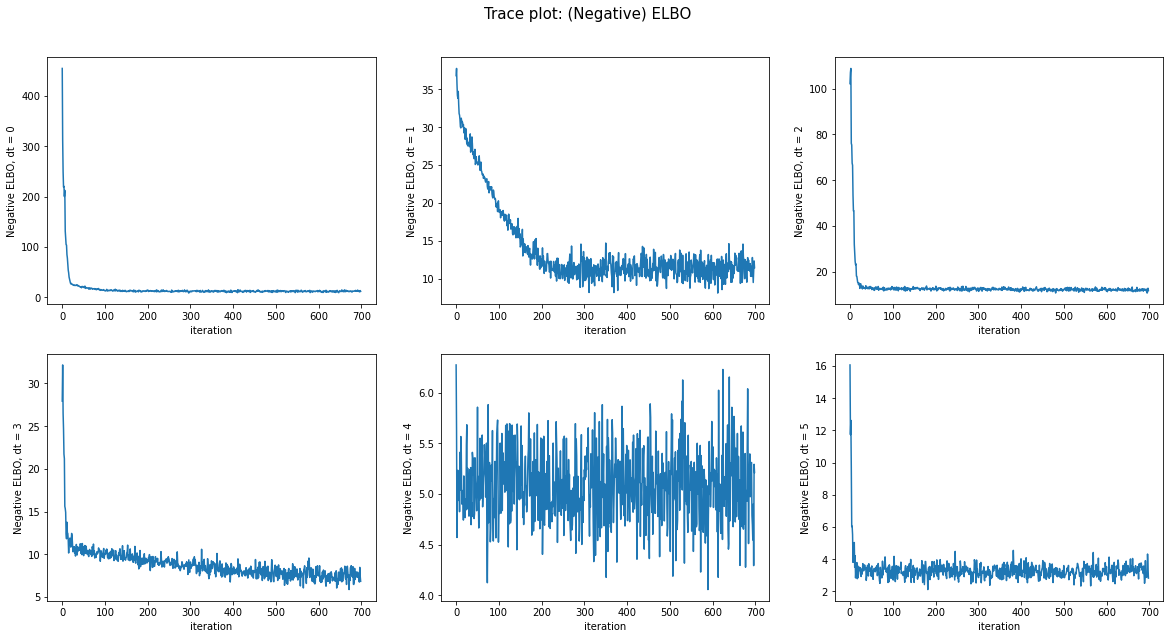

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(elbo_traces[t, :])), elbo_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) ELBO", size=15, y=0.95)
plt.show()

Trace plot: KL divergence

Note that the KL divergence is always strictly greater than 0. 

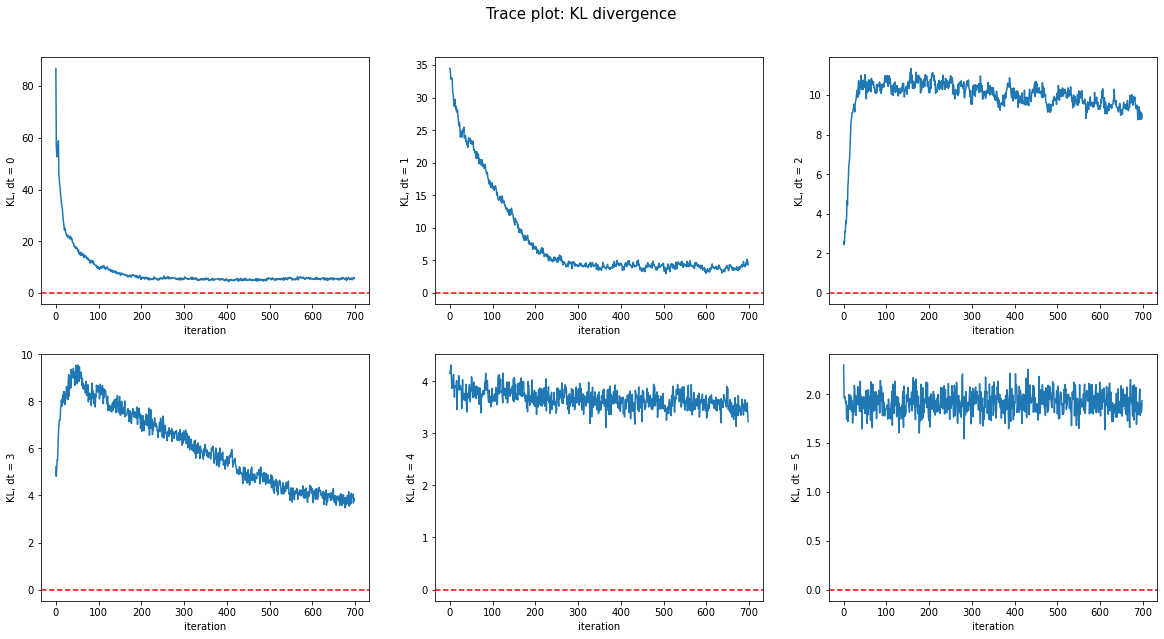

In [35]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(KL_traces[t, :])), -1 * KL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("KL, dt = %d" % t)
    ax.axhline(0, color='red', linestyle='dashed')
    t += 1
    
plt.suptitle("Trace plot: KL divergence", size=15, y=0.95)
plt.show()

Trace plot: NLL

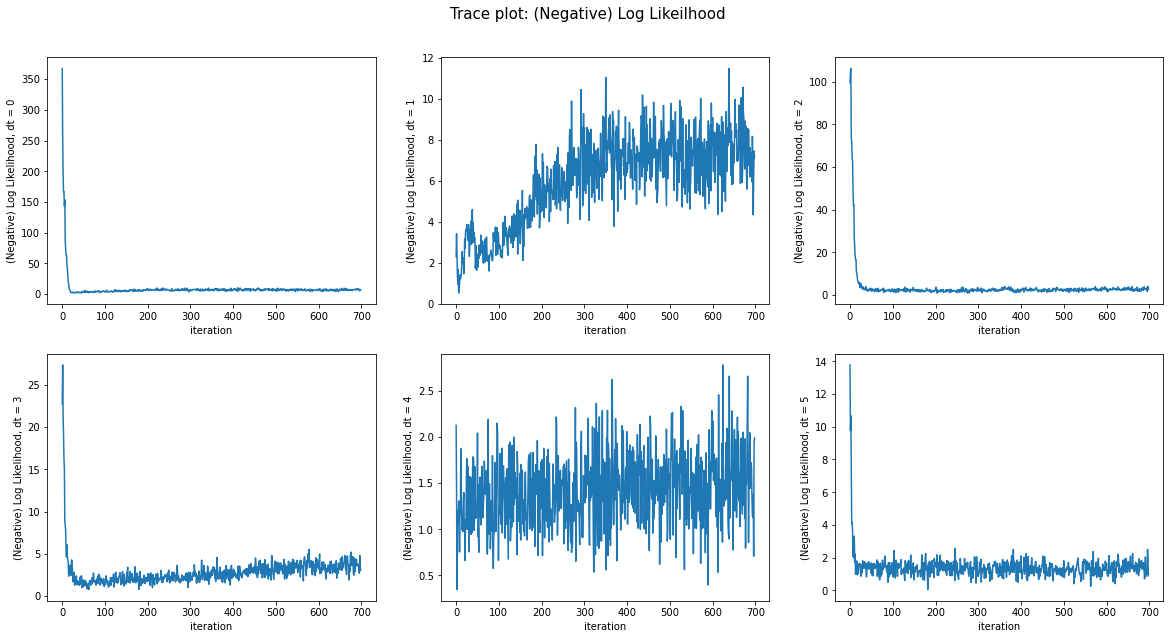

In [36]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(LL_traces[t, :])), -1 * LL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("(Negative) Log Likelihood, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) Log Likeilhood", size=15, y=0.95)
plt.show()

Trace plot: parameters

Note that $\beta$ trace plot suggests that the algorithm did not reach its stationary regime yet. Nonetheless, the resulting variational inference looks fine

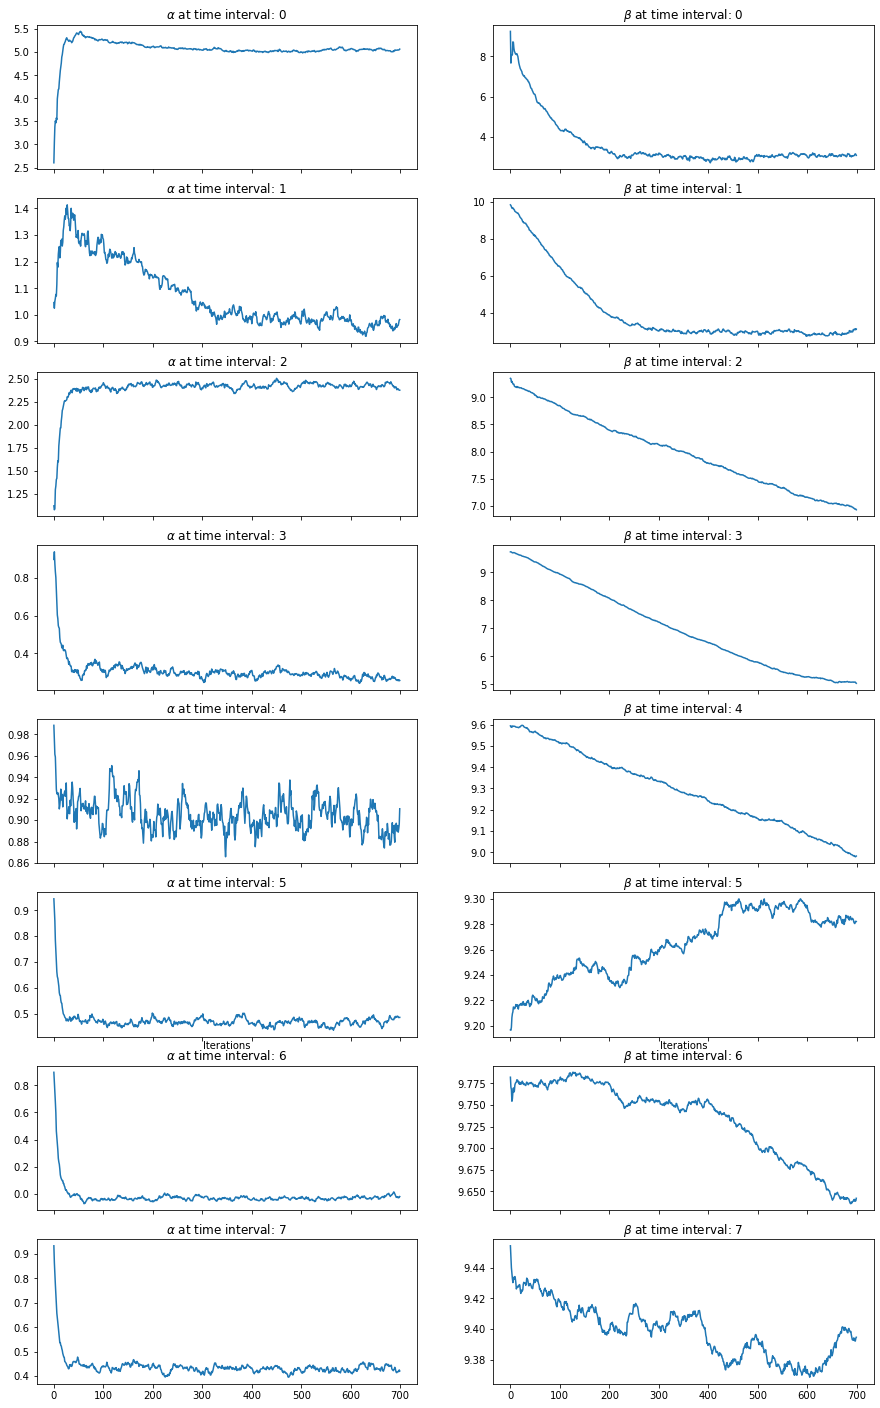

In [37]:
fig, ax = plt.subplots(nrows=pars_traces.shape[1], ncols=2, figsize=(15, 25), sharex='all')
names = [r'$\alpha$', r'$\beta$']
for j, ax in enumerate(ax.ravel()):
    i = j % 2
    t = j // 2
    ax.plot(np.arange(pars_traces[i, t, :].shape[0]), pars_traces[i, t, :])
    ax.set_title(names[i] + " at time interval: %d" % t)
#     ax.set_yticks(np.linspace(0,2,10))
    if t == 5:
        ax.set_xlabel("Iterations")
plt.show()

**Posterior approximation**

Variational posterior process clearly shows a lack of flexibility of its form. 

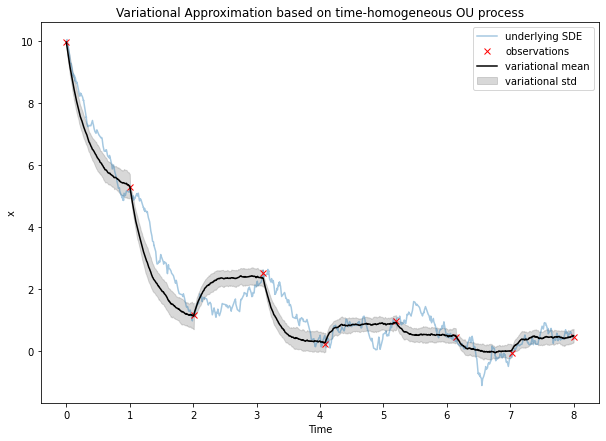

In [38]:
vi_mean = np.concatenate(vp_mean)
vi_var = np.concatenate(vp_std)
vi_pts = np.concatenate(vp_pts)

plt.figure(figsize=(10, 7))
plt.plot(true_sde.pts.T, true_sde.trj.T, label="underlying SDE", alpha=0.4)
plt.plot(obs_time, obs, 'rx', label='observations')
plt.plot(vi_pts, vi_mean, color='black', label='variational mean')
plt.fill_between(vi_pts, vi_mean + vi_var, vi_mean - vi_var, alpha=0.3, color='grey', label='variational std')
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Variational Approximation based on time-homogeneous OU process")
plt.show()